**Data Source:** Pleschberger, Martin, Zernig, Anja, & Kaestner, Andre. (2020). Equipment Sensor Data from Semiconductor Frontend Production (Version 1) [Data set]. Zenodo. http://doi.org/10.5281/zenodo.4282611

In [1]:
import os
import pandas as pd
pd.options.display.max_columns = 100

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
sensors_1_to_24 = pd.read_csv('equipment1.csv', sep=';')
sensors_25_to_56 = pd.read_csv('equipment2.csv', sep=';')
response = pd.read_csv('response.csv', sep=';')

In [3]:
sensors_1_to_24.lot = sensors_1_to_24.lot.str.replace('lot', '').astype('int64')
sensors_1_to_24.timestamp = sensors_1_to_24.timestamp.str.replace('timestamp_', '').astype('int64')

sensors_25_to_56.lot = sensors_25_to_56.lot.str.replace('lot', '').astype('int64')
sensors_25_to_56.timestamp = sensors_25_to_56.timestamp.str.replace('timestamp_', '').astype('int64')

In [4]:
grouped_data_1_to_24 = sensors_1_to_24.groupby(['lot', 'wafer']).mean().sort_values('lot')
grouped_data_25_to_56 = sensors_25_to_56.groupby(['lot', 'wafer']).mean().sort_values('lot')

In [5]:
response['lot'] = response['lot'].str.replace('lot', '').astype('int64')
response['class'] = response['class'].replace(['good', 'bad'], [1, 0]).astype('int64')
grouped_response = response.groupby(['lot', 'wafer']).mean().sort_values('lot')

In [6]:
print(len(grouped_response.index) - len(grouped_data_25_to_56.index))
print(len(grouped_response.index) - len(grouped_data_1_to_24.index))
print(len(grouped_response.index))

0
348
1319


In [7]:
sensor_data = grouped_data_1_to_24.join(grouped_data_25_to_56, how='outer', lsuffix='_1_to_24', rsuffix='_25_to_56')
data = sensor_data.join(grouped_response, how='outer')

In [8]:
data = data.fillna(0)
print(len(grouped_response.index))

1319


In [9]:
data.sample(3)

,,timestamp_1_to_24,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,timestamp_25_to_56,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,sensor_52,sensor_53,sensor_54,sensor_55,sensor_56,response,class
lot,wafer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
74,16,87.5,2.812582,2.812500,65.639352,19.715777,19.715909,0.0,11.641722,0.689258,7.136364,11.517784,12.323864,0.0,0.260455,0.260455,0.259659,0.259659,6.045455,382.639267,99.087092,17.625000,1122.727273,206.261545,433.028409,0.857841,87.5,0.001395,48.142533,59.6250,6.625000,0.001761,20.446364,10.647171,74.990887,0.0,0.001860,37.362067,0.0,22.339202,43.533612,39.914881,192.605608,3.495479,119.673826,121.335526,1.005682,185.388220,30.641932,1024.372744,15.733182,175.926136,29.623864,170.705114,120.499905,381.647031,0.000007,0.481654,0.602216,0.3816,1
49,21,87.5,5.109734,5.202273,13.922113,43.319705,43.007102,0.0,9.897292,1.968791,7.750000,12.305966,13.812500,0.0,0.267520,0.267520,0.267520,0.267520,6.482955,407.652102,95.535687,9.931818,89.164773,215.723341,487.653409,1.033580,87.5,0.001411,137.026221,62.4375,6.937500,0.000000,21.255682,10.611534,75.363347,0.0,0.001841,39.141830,0.0,20.476012,41.336699,39.569259,175.544289,2.436903,124.575164,127.349068,1.073864,439.530622,30.791250,692.905369,15.708864,175.289773,30.317045,172.172727,126.180683,0.000006,366.338358,0.530009,0.630682,0.3906,1
72,25,87.5,5.107488,5.198864,13.924553,43.273928,42.996307,0.0,10.012632,2.016996,7.744318,12.267614,13.744318,0.0,0.267537,0.267537,0.267537,0.267537,6.482955,407.847631,96.002501,10.085227,89.709659,215.723386,487.653409,1.033920,87.5,0.001430,319.004047,64.6875,7.670455,0.002216,21.298295,10.453130,76.174216,0.0,0.001884,40.509353,0.0,24.711496,43.329071,40.026411,196.007292,3.757522,130.122432,131.915392,1.113636,888.843614,30.696705,889.207415,15.866080,177.329545,30.109659,177.078409,130.731410,364.153455,0.000006,0.499119,0.653523,0.4104,1


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1319 entries, (2, 1) to (103, 25)
Data columns (total 60 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp_1_to_24   1319 non-null   float64
 1   sensor_1            1319 non-null   float64
 2   sensor_2            1319 non-null   float64
 3   sensor_3            1319 non-null   float64
 4   sensor_4            1319 non-null   float64
 5   sensor_5            1319 non-null   float64
 6   sensor_6            1319 non-null   float64
 7   sensor_7            1319 non-null   float64
 8   sensor_8            1319 non-null   float64
 9   sensor_9            1319 non-null   float64
 10  sensor_10           1319 non-null   float64
 11  sensor_11           1319 non-null   float64
 12  sensor_12           1319 non-null   float64
 13  sensor_13           1319 non-null   float64
 14  sensor_14           1319 non-null   float64
 15  sensor_15           1319 non-null   float64
 

In [11]:
data.describe()

,timestamp_1_to_24,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,timestamp_25_to_56,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,sensor_52,sensor_53,sensor_54,sensor_55,sensor_56,response,class
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.0,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1.319000e+03,1319.000000,1319.000000,1319.000000
mean,64.414329,2.994615,3.033734,27.737953,23.849106,23.813934,0.101126,7.849907,0.708233,5.411047,8.633491,9.515757,0.218351,0.194300,0.194300,0.194019,0.194008,4.573851,290.510271,78.360541,9.840982,231.050492,155.186543,345.345622,0.700146,87.5,0.001403,154.539367,61.388629,7.010709,0.001700,20.873311,10.445576,75.038648,0.000202,0.001861,38.326207,0.000207,23.872753,41.882245,39.580997,189.514677,2.650611,122.333376,124.302022,1.040673,453.448962,30.591545,783.977135,15.756765,176.676296,30.255056,175.282816,123.584465,198.086621,195.264637,5.419853e-01,0.617882,0.610433,0.799848
std,38.576888,2.067209,2.081444,27.952776,17.395009,17.355720,0.483888,4.857079,0.728064,3.246610,5.178566,5.712414,0.951764,0.116435,0.116435,0.116277,0.116271,2.742306,174.196679,51.773140,6.711553,413.825437,92.994311,207.101672,0.425157,0.0,0.000049,79.418785,4.539808,0.561165,0.001149,0.716157,0.336480,2.559284,0.007353,0.000053,2.818333,0.007509,1.999914,1.827950,1.694330,10.079443,0.658755,9.044779,9.225132,0.090416,226.612973,1.590658,407.874725,0.600415,4.661447,1.611555,4.716476,9.136877,197.519613,196.568782,1.158684e-01,0.045494,0.442395,0.400265
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,87.5,0.001222,4.216210,50.625000,5.585227,0.000000,18.742386,9.322899,64.197888,0.000000,0.001696,31.725676,0.000000,19.200304,36.798038,35.246175,161.202755,0.962720,101.008813,102.426010,0.892045,14.255641,26.636136,72.361073,13.941364,158.500000,25.422727,153.122727,102.367403,0.000003,0.000002,2.907170e-07,0.511534,0.360000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,87.5,0.001373,103.390709,60.187500,6.778409,0.000000,20.446023,10.218000,73.090327,0.000000,0.001817,37.687526,0.000000,22.598349,40.602276,38.329930,182.127009,2.208014,119.956132,121.636887,1.011364,295.523954,29.430682,452.774723,15.326705,173.210227,29.096591,172.103693,121.243535,0.000007,0.000007,4.892623e-01,0.607131,0.396000,1.000000
50%,87.500000,2.812623,2.812500,13.669946,19.861540,19.857955,0.000000,9.508514,0.585703,7.170455,11.517330,12.755682,0.000000,0.260739,0.260739,0.259886,0.259830,6.085227,387.806114,98.212212,10.028409,80.308523,208.935131,456.392045,0.864318,87.5,0.001403,147.633078,61.312500,6.937500,0.002045,21.013977,10.463086,75.162172,0.000000,0.001860,38.053884,0.000000,24.341112,41.

In [12]:
#categorical vs continuous sensor types

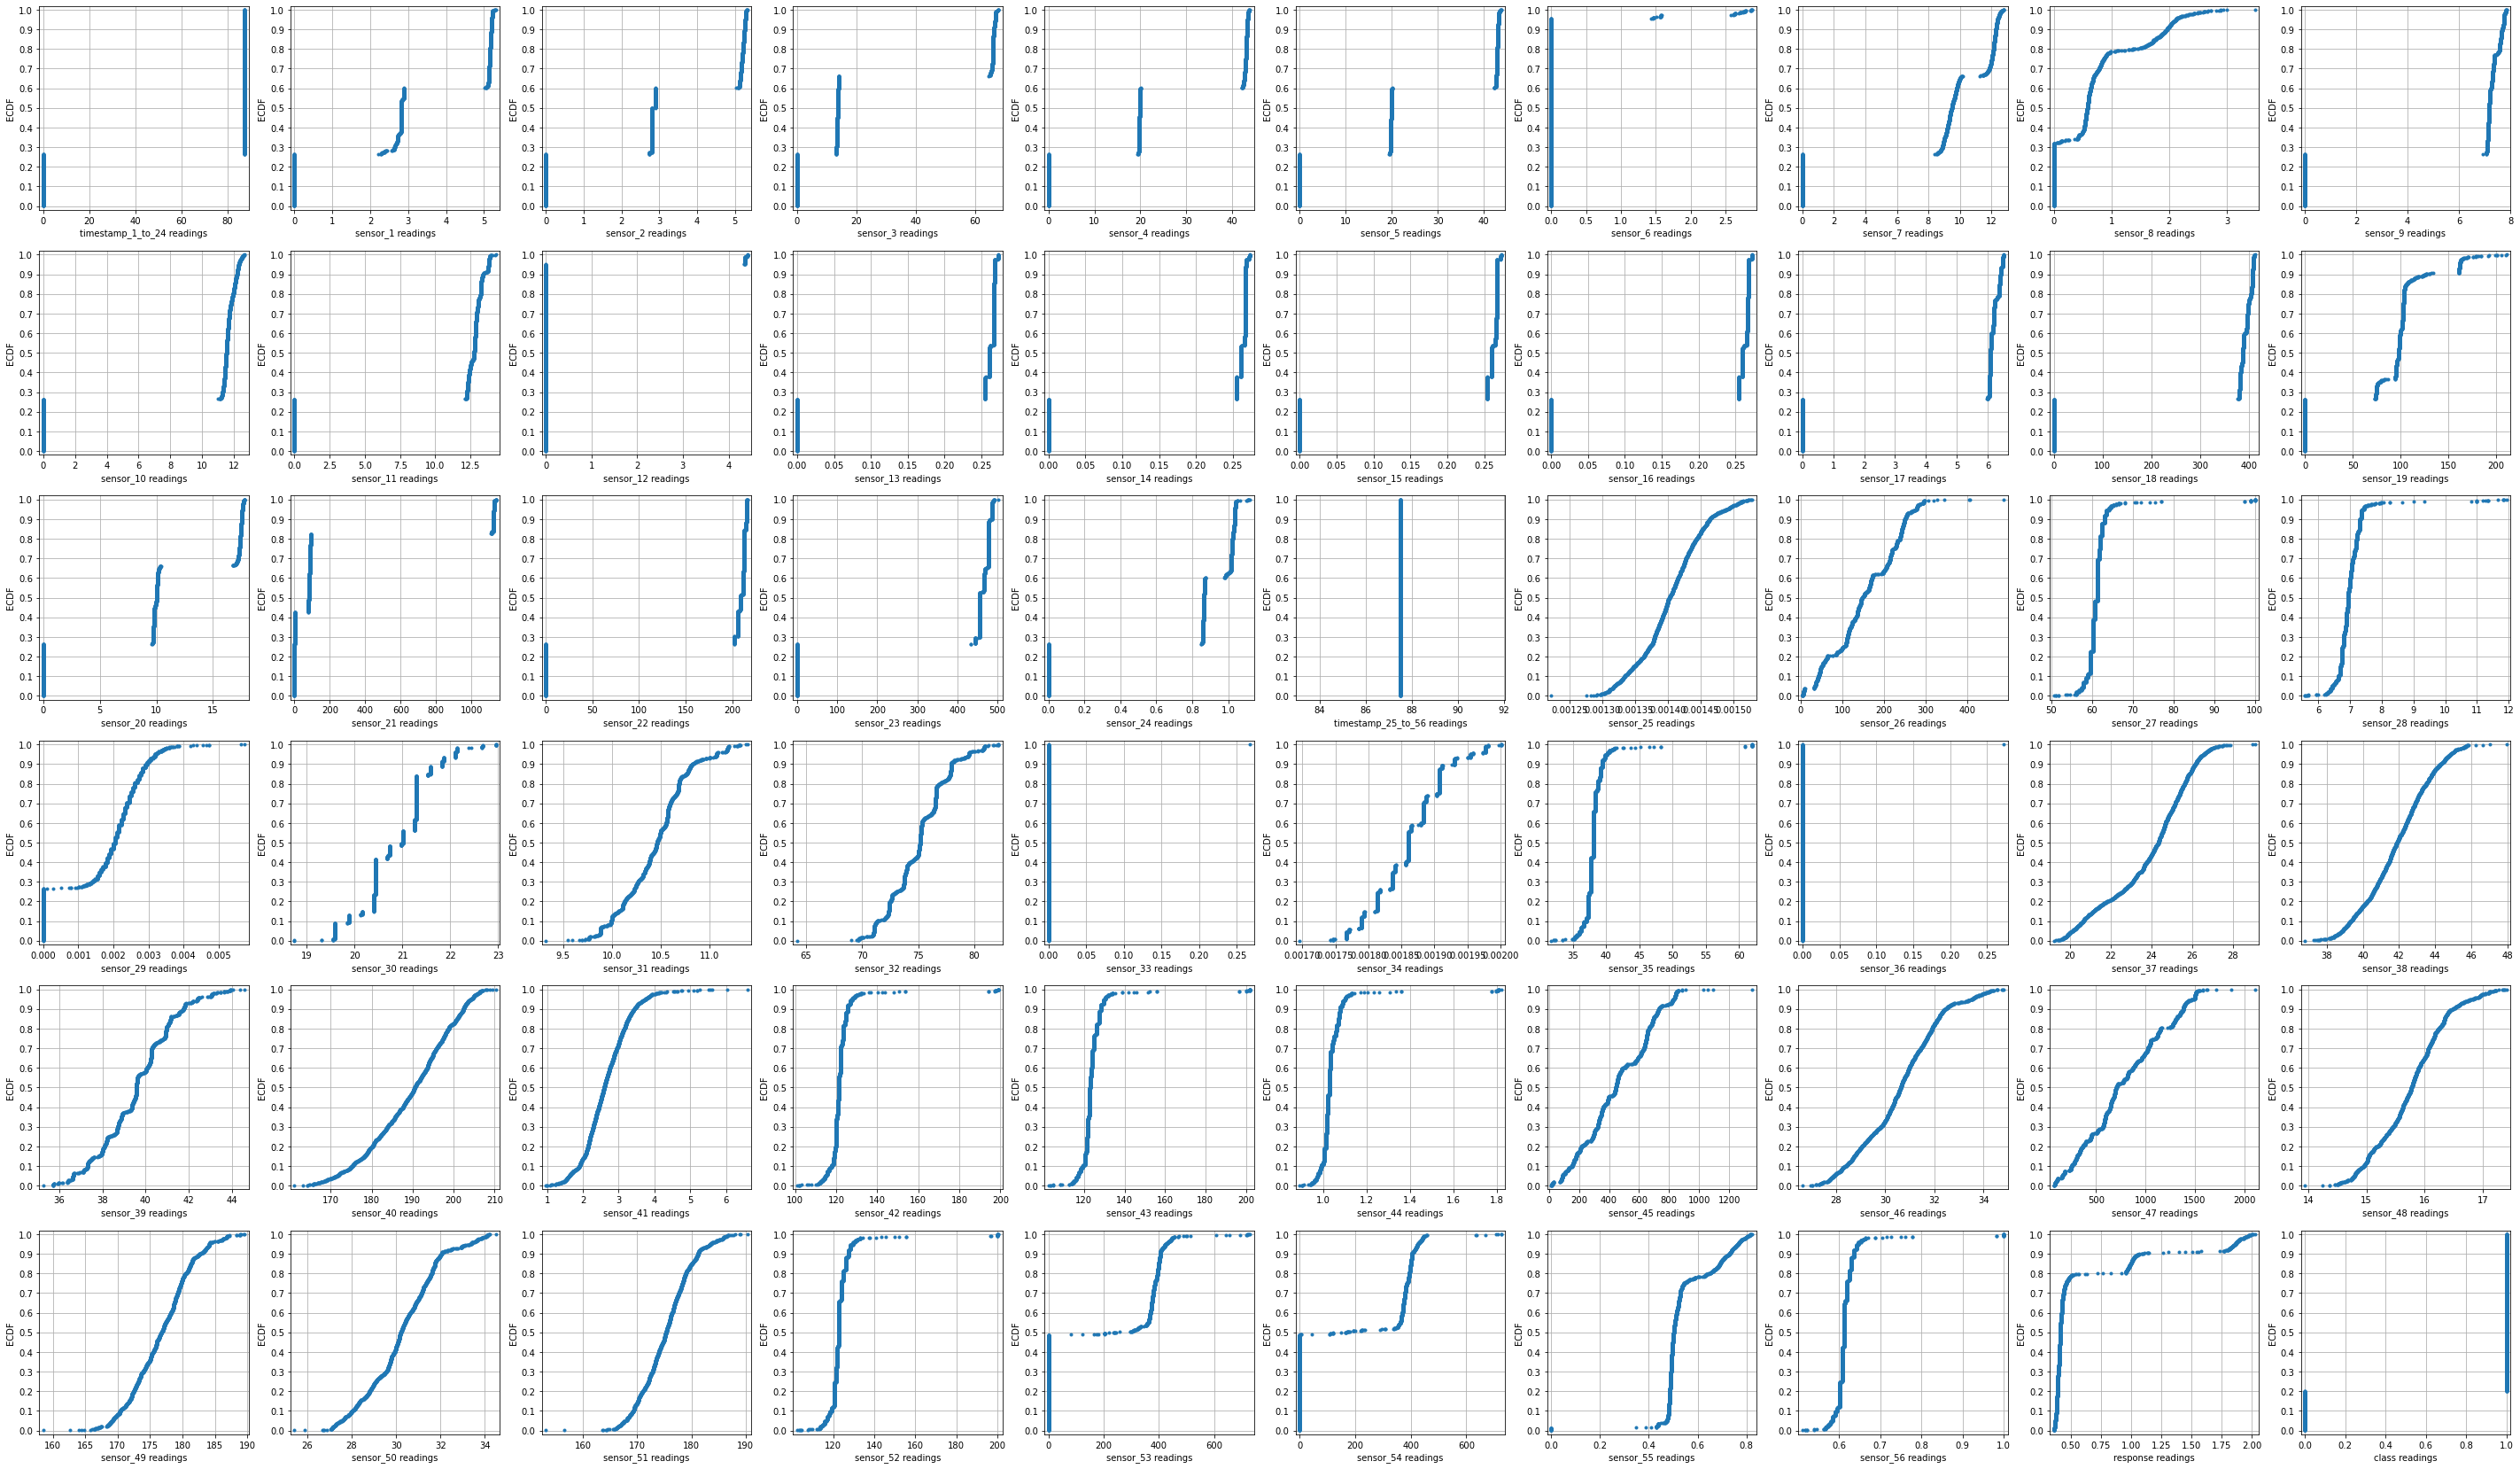

In [13]:
#ECDF plots
def ECDF(df_column):  
    x = np.sort(df_column)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

#plt.style.use('seaborn')
plt.figure(figsize=(50.0,50.0))
for ax, n in list(enumerate(data.columns)):
    x, y = ECDF(data[n])
    plt.subplot(10, 10, ax+1)
    plt.grid(True)
    x_ecdf = plt.plot(x, y, marker='.', linestyle='none')
    plt.xlabel('%s readings' %n)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.ylabel('ECDF')
    plt.margins(0.02)


In [14]:
print(data.shape)
data.head()

(1319, 60)


timestamp_1_to_24  sensor_1  sensor_2   sensor_3   sensor_4  \
lot wafer                                                                
2   1                   87.5  5.231203  5.176705  13.251176  42.618787   
    2                   87.5  5.196315  5.142614  13.666808  43.419169   
    3                   87.5  5.161432  5.255114  13.243853  42.981363   
    4                   87.5  5.175509  5.294318  13.671360  43.151993   
    5                   87.5  5.201729  5.127273  13.332878  43.262745   

            sensor_5  sensor_6  sensor_7  sensor_8  sensor_9  sensor_10  \
lot wafer                                                                 
2   1      43.066761       0.0  8.505448       0.0  7.267045  11.703011   
    2      43.147443       0.0  9.167583       0.0  7.607955  11.960227   
    3      42.650795       0.0  8.666924       0.0  7.295455  11.563523   
    4      42.904432       0.0  9.621476       0.0  7.613636  12.191591   
    5      43.001705       0.0  9.275963       0.0  7.335227  11.556989   

           sensor_11  sensor_12  sensor_13  sensor_14  sensor_15  sensor_16  \
lot wafer                                                                     
2   1      12.346591        0.0   0.266298   0.266298   0.266298   0.266298   
    2      12.761364        0.0   0.266162   0.266162   0.266162   0.266162   
    3      12.551136        0.0   0.266903   0.266903   0.266903   0.266903   
    4      13.215909        0.0   0.267062   0.267062   0.267062   0.267062   
    5      12.568182        0.0   0.266392   0.266392   0.266392   0.266392   

           sensor_17   sensor_18   sensor_19  sensor_20  sensor_21  \
lot wafer                                                            
2   1       6.164773  398.018165  126.723761   9.778409  79.217614   
    2       6.363636  408.363824  201.201568  10.329545  88.847159   
    3       6.164773  398.137699  113.195898   9.727273  79.772727   
    4       6.363636  408.062517  179.183085  10.164773  88.403409   
    5       6.204545  398.231636  107.544619   9.715909  80.952273   

            sensor_22   sensor_23  sensor_24  timestamp_25_to_56  sensor_25  \
lot wafer                                                                     
2   1      208.905500  467.232955   0.983864                87.5   0.001495   
    2      208.953966  467.204545   1.017557                87.5   0.001500   
    3      212.313545  477.465909   0.987557                87.5   0.001505   
    4      212.313250  477.437500   1.015966                87.5   0.001509   
    5      208.906159  467.227273   1.011364                87.5   0.001499   

            sensor_26  sensor_27  sensor_28  sensor_29  sensor_30  sensor_31  \
lot wafer                                                                      
2   1      232.694903    60.1875     6.6875        0.0  21.821591  11.296246   
    2      245.951321    63.5625     7.0625        0.0  22.105284  10.849002   
    3      243.975941    63.0000     7.0000        0.0  21.821420  11.063067   
    4      246.357599    63.5625     7.0625        0.0  22.105057  10.858582   
    5      246.561347    63.5625     7.0625        0.0  22.104545  11.069689   

           sensor_32  sensor_33  sensor_34  sensor_35  sensor_36  sensor_37  \
lot wafer                                                                     
2   1      79.692877        0.0   0.001977  37.624962        0.0  21.595660   
    2      80.814970        0.0   0.001973  39.854000        0.0  22.763340   
    3      80.783452        0.0   0.001954  39.408217        0.0  22.018238   
    4      80.050300        0.0   0.001954  39.754566        0.0  21.757269   
    5      80.733545        0.0   0.001977  39.854118        0.0  22.053265   

           sensor_38  sensor_39   sensor_40  sensor_41   sensor_42  \
lot wafer                                                            
2   1      44.118530  42.609528  189.509110   1.660068  120.094154   
    2      45.344954  43.932713  196.95882

In [15]:
## look into correlation mapping to see if one sensor is dependent on another
#plt.figure(figsize=(10,10))
#sns.heatmap(data.corr())
#print(data.corr()['sensor_55'].tail(10))
print(data.corr()['response'].sort_values().head())

class       -0.896568
sensor_47   -0.316494
sensor_3    -0.300205
sensor_46   -0.260492
sensor_34   -0.259675
Name: response, dtype: float64


In [16]:
X = data.drop('class', axis=1).astype('int64')
y = data['class'].astype('int64')

In [17]:
print(X.shape)
print(y.shape)

(1319, 59)
(1319,)


In [18]:
pca = PCA(n_components=2)
X_pca = pca.fit(X)
X_pca = pca.transform(X)
print(X_pca.shape)
print(y.shape)

(1319, 2)
(1319,)


In [19]:
X_pca = pd.DataFrame(normalize(X_pca), columns=['PCA1', 'PCA2'])
print(X_pca.shape)
print(y.shape)
X_pca.head()

(1319, 2)
(1319,)


,PCA1,PCA2
0,0.655219,-0.755439
1,0.703028,-0.711162
2,0.668414,-0.743790
3,0.704881,-0.709326
4,0.668373,-0.743826


In [20]:
X = X_pca
print(X.shape)
print(y.shape)

(1319, 2)
(1319,)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=314)

In [22]:
scaler = StandardScaler(with_mean=True)
scaler.fit(X_train)
scaler.transform(X_train);
scaler.transform(X_test);

In [23]:
print(X_train.head())
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

         PCA1      PCA2
880 -0.859291  0.511487
621 -0.876643  0.481142
473 -0.778737 -0.627351
542  0.640260 -0.768159
847 -0.977270  0.211997
(923, 2)
(923,)
(396, 2)
(396,)


In [24]:
lin_reg = LinearRegression()
log_reg = LogisticRegression(max_iter=100)
rand_for = RandomForestClassifier()

In [25]:
#lin_reg.fit(X_train, y_train)
#y_pred_train = lin_reg.predict(X_train)
#y_pred_test = lin_reg.predict(X_test)

In [26]:
#log_reg.fit(X_train, y_train)
#y_pred_train = log_reg.predict(X_train)
#y_pred_test = log_reg.predict(X_test)

In [27]:
rand_for.fit(X_train, y_train)
y_pred_train = rand_for.predict(X_train)
y_pred_test = rand_for.predict(X_test)

In [28]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_pred_test.shape)

(923, 2)
(923,)
(396, 2)
(396,)
(396,)


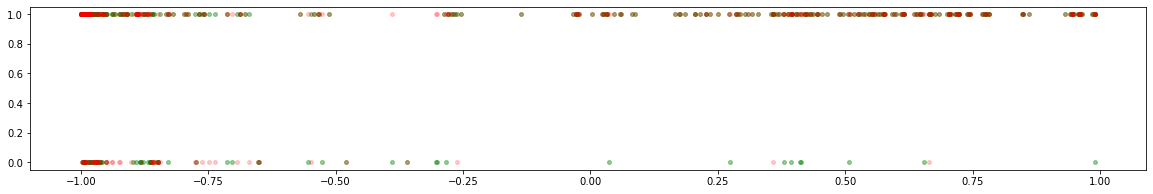

In [29]:
#plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.figure(figsize=(20,3))
plt.scatter(X_test['PCA1'], y_test, c='green', s=15, alpha=0.4);
plt.scatter(X_test['PCA1'], y_pred_test, c='red', s=15, alpha=0.2);

In [30]:
print(classification_report(y_test, y_pred_test, labels=[0,1]))
print(classification_report(y_train, y_pred_train, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.42      0.41      0.41        69
           1       0.88      0.88      0.88       327

    accuracy                           0.80       396
   macro avg       0.65      0.64      0.65       396
weighted avg       0.80      0.80      0.80       396

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       195
           1       1.00      1.00      1.00       728

    accuracy                           1.00       923
   macro avg       1.00      1.00      1.00       923
weighted avg       1.00      1.00      1.00       923

